In [1]:
import re, ast, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



# ============================================================
# 1) Parse TXT -> DataFrame
# ============================================================

def parse_results_txt(txt_path):
    rows = []

    header_re = re.compile(
        r"dataset=(?P<dataset>.*?)\s*\|\s*file=(?P<file>.*?)\s*\|\s*n=(?P<n>.*?)\s*\|\s*"
        r"Gamma=(?P<Gamma>.*?)\s*\|\s*solver=(?P<solver>.*?)\s*\|\s*"
        r"runtime=(?P<runtime>[\d\.]+)s\s*\|\s*val=(?P<val>.*)"
    )

    path_re = re.compile(r"optimal_path_arcs=(?P<path>\[.*\])")

    cur = None

    with open(txt_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()

            m = header_re.match(line)
            if m:
                if cur is not None:
                    rows.append(cur)

                cur = m.groupdict()

                # type casting
                cur["n"] = None if cur["n"] == "NA" else int(float(cur["n"]))
                cur["Gamma"] = float(cur["Gamma"]) if cur["Gamma"] not in ("NA", "") else None
                cur["runtime"] = float(cur["runtime"]) if cur["runtime"] not in ("NA", "") else math.nan
                try:
                    cur["val"] = float(cur["val"])
                except Exception:
                    cur["val"] = math.nan

                cur["path_arcs"] = None
                continue

            if cur is not None:
                pm = path_re.match(line)
                if pm:
                    # store the raw list text; we can eval safely with ast.literal_eval later
                    cur["path_arcs"] = pm.group("path")
                    continue

        if cur is not None:
            rows.append(cur)

    df = pd.DataFrame(rows)

    # convert path_arcs text -> python object
    import ast
    def _to_list(x):
        if not isinstance(x, str) or x.strip() == "" or x.strip() == "None":
            return None
        try:
            return ast.literal_eval(x)
        except Exception:
            return None

    df["path_arcs"] = df["path_arcs"].apply(_to_list)

    return df


# ============================================================
# 2) Plotting functions (same idea as before)
# ============================================================

def plot_box_per_dataset(df, dataset_name):
    sub = df[df["dataset"] == dataset_name].copy()
    sub["grp"] = sub["Gamma"].astype(int).astype(str) + "-" + sub["solver"]

    labels = sorted(
        sub["grp"].unique(),
        key=lambda s: (int(s.split("-")[0]), s.split("-")[1])
    )

    groups = [sub[sub["grp"] == g]["runtime"].values for g in labels]

    plt.figure(figsize=(11, 5))
    plt.boxplot(groups, tick_labels=labels)
    plt.ylabel("runtime (s)")
    plt.title(f"Runtime distribution: {dataset_name}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def plot_bar_mean_per_dataset(df, dataset_name):
    sub = df[df["dataset"] == dataset_name].copy()

    mean_df = (
        sub.groupby(["Gamma", "solver"], as_index=False)["runtime"]
           .mean()
           .sort_values(["Gamma", "solver"])
    )

    gammas = sorted(mean_df["Gamma"].unique())
    solvers = sorted(mean_df["solver"].unique())

    width = 0.35
    x = list(range(len(gammas)))

    plt.figure(figsize=(12, 4))
    for si, solver in enumerate(solvers):
        y = []
        for g in gammas:
            row = mean_df[(mean_df["Gamma"] == g) & (mean_df["solver"] == solver)]
            y.append(float(row["runtime"].iloc[0]) if len(row) else float("nan"))

        shift = (-width/2) if si == 0 else (width/2)
        plt.bar([xi + shift for xi in x], y, width=width, label=solver)

    plt.xticks(x, [int(g) if float(g).is_integer() else g for g in gammas])
    plt.xlabel("Gamma")
    plt.ylabel("mean runtime (s)")
    plt.title(f"Mean runtime: {dataset_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()


# ============================================================
# 3) Example usage in a new notebook
# ============================================================



    dataset        file   n  Gamma    solver   runtime   val  \
0  js30path  j3010_1.sm  32    1.0  SHIMRITS  0.138381  45.5   
1  js30path  j3010_1.sm  32    1.0     bruni  0.039243  45.5   
2  js30path  j3010_1.sm  32    2.0  SHIMRITS  0.017916  50.0   
3  js30path  j3010_1.sm  32    2.0     bruni  0.024843  50.0   
4  js30path  j3010_1.sm  32    3.0  SHIMRITS  0.017506  53.5   

                                           path_arcs  
0  [(0, 3), (3, 4), (4, 7), (7, 12), (12, 19), (1...  
1  [(0, 3), (3, 4), (4, 7), (7, 12), (12, 19), (1...  
2  [(0, 3), (3, 4), (4, 7), (7, 12), (12, 19), (1...  
3  [(0, 3), (3, 4), (4, 7), (7, 12), (12, 19), (1...  
4  [(0, 3), (3, 4), (4, 7), (7, 11), (11, 29), (2...  
Rows: 43200


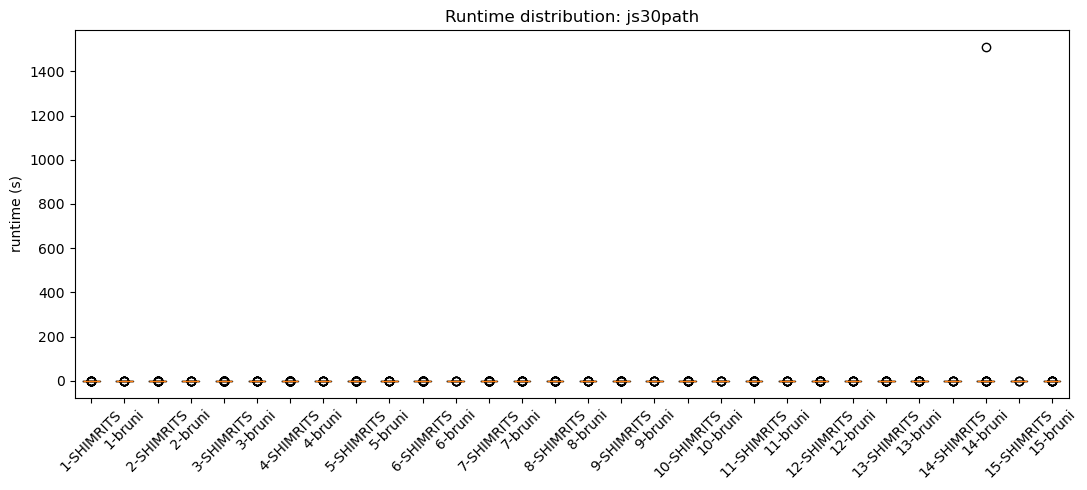

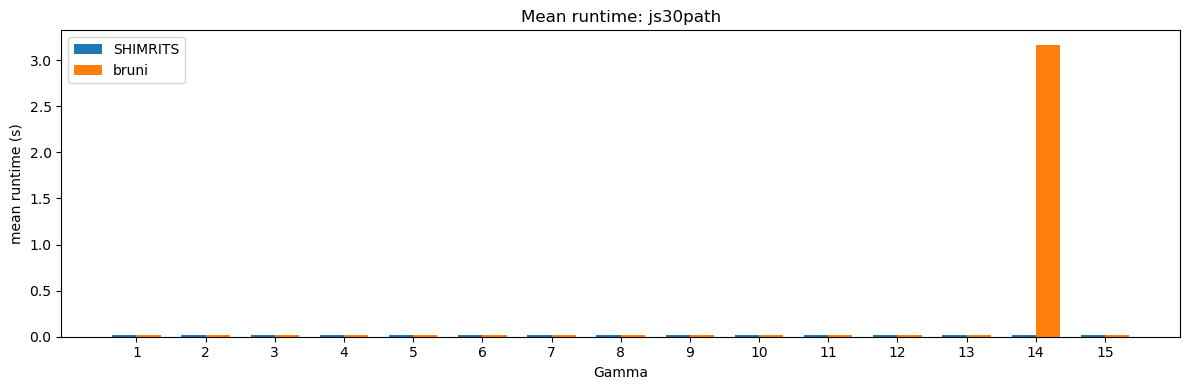

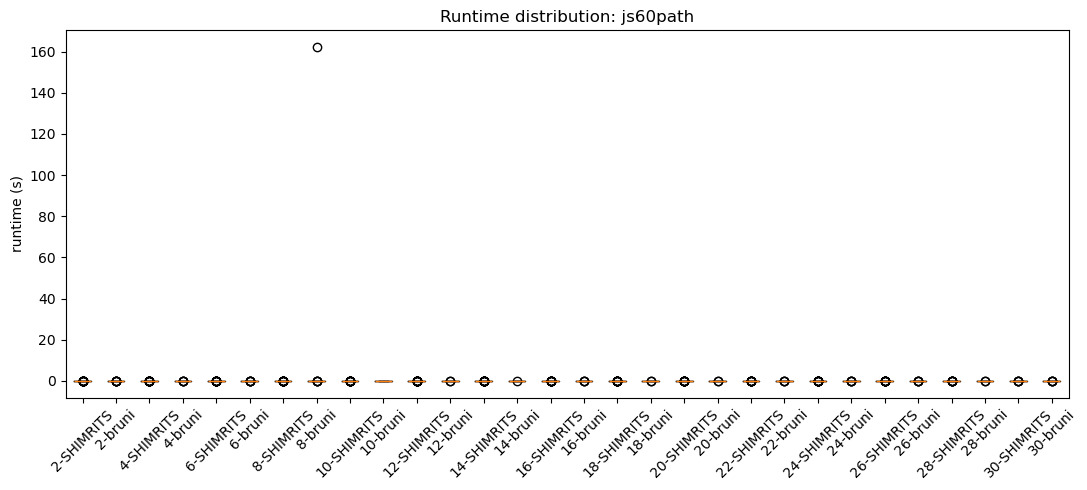

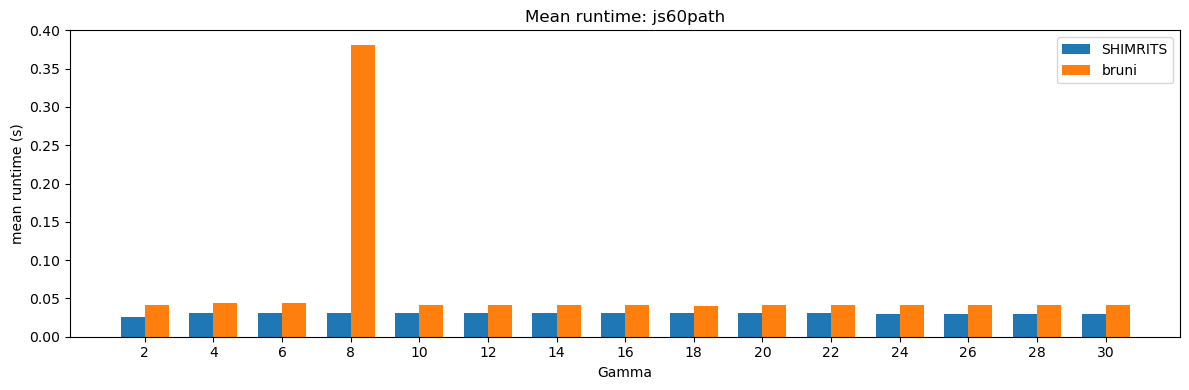

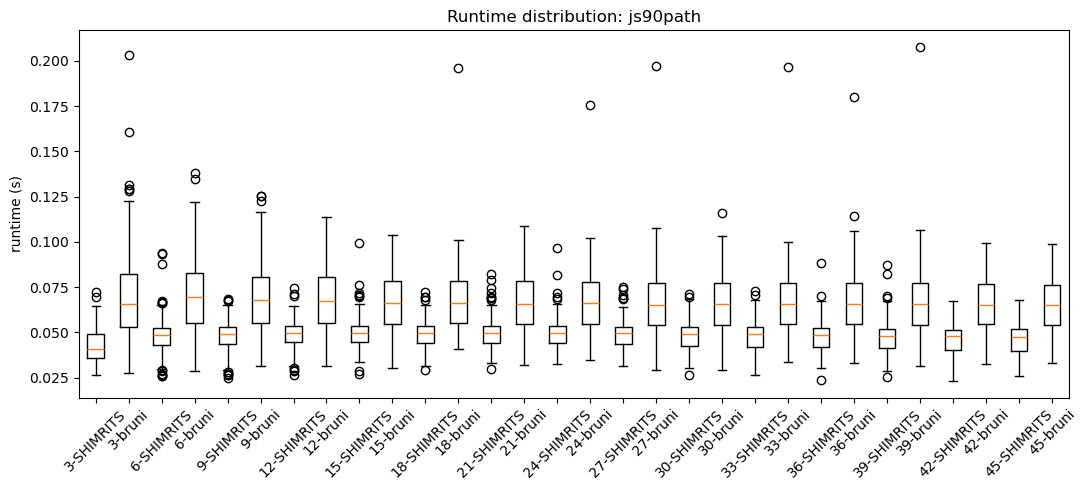

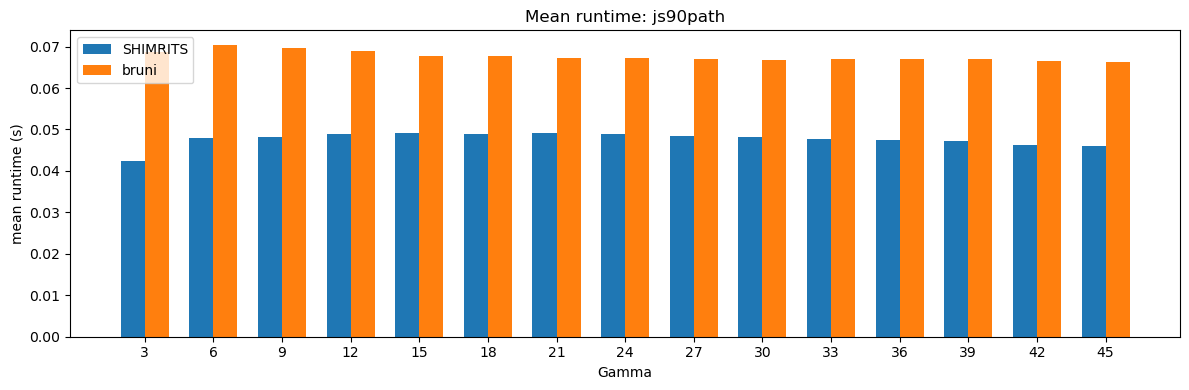

In [2]:
txt_files = [
    "results_js30path.txt",
    "results_js60path.txt",
    "results_js90path.txt",
]

dfs = [parse_results_txt(p) for p in txt_files]
df = pd.concat(dfs, ignore_index=True)

print(df.head())
print("Rows:", len(df))

for ds in sorted(df["dataset"].unique()):
    plot_box_per_dataset(df, ds)
    plot_bar_mean_per_dataset(df, ds)


In [3]:
def plot_bar_median_per_dataset(df, dataset_name):
    sub = df[df["dataset"] == dataset_name].copy()

    med_df = (
        sub.groupby(["Gamma", "solver"], as_index=False)["runtime"]
           .median()
           .rename(columns={"runtime": "median_runtime"})
           .sort_values(["Gamma", "solver"])
    )

    gammas = sorted(med_df["Gamma"].unique())
    solvers = sorted(med_df["solver"].unique())

    width = 0.35
    x = list(range(len(gammas)))

    plt.figure(figsize=(12, 4))
    for si, solver in enumerate(solvers):
        y = []
        for g in gammas:
            row = med_df[(med_df["Gamma"] == g) & (med_df["solver"] == solver)]
            y.append(float(row["median_runtime"].iloc[0]) if len(row) else float("nan"))

        shift = (-width/2) if si == 0 else (width/2)
        plt.bar([xi + shift for xi in x], y, width=width, label=solver)

    plt.xticks(x, [int(g) if float(g).is_integer() else g for g in gammas])
    plt.xlabel("λ (Gamma)")
    plt.ylabel("median runtime (s)")
    plt.title(f"Median runtime by λ: {dataset_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [4]:
def plot_hist_runtime_per_solver_all_gammas(df, dataset_name, bins=30):
    sub = df[df["dataset"] == dataset_name].copy()
    solvers = sorted(sub["solver"].unique())

    for solver in solvers:
        s = sub[sub["solver"] == solver]["runtime"].dropna().values
        plt.figure(figsize=(7, 4))
        plt.hist(s, bins=bins)
        plt.xlabel("runtime (s)")
        plt.ylabel("count")
        plt.title(f"Runtime histogram (all λ) | {dataset_name} | {solver}")
        plt.tight_layout()
        plt.show()


In [5]:
def plot_hist_runtime_by_gamma_grid(df, dataset_name, solver, bins=20, max_cols=5):
    sub = df[(df["dataset"] == dataset_name) & (df["solver"] == solver)].copy()
    gammas = sorted(sub["Gamma"].unique())

    nplots = len(gammas)
    ncols = min(max_cols, nplots)
    nrows = int(np.ceil(nplots / ncols))

    plt.figure(figsize=(3.2*ncols, 2.6*nrows))

    for idx, g in enumerate(gammas, start=1):
        ax = plt.subplot(nrows, ncols, idx)
        s = sub[sub["Gamma"] == g]["runtime"].dropna().values
        ax.hist(s, bins=bins)
        ax.set_title(f"λ={int(g) if float(g).is_integer() else g}")
        ax.set_xlabel("runtime (s)")
        ax.set_ylabel("count")

    plt.suptitle(f"Runtime histograms by λ | {dataset_name} | {solver}", y=1.02)
    plt.tight_layout()
    plt.show()


In [8]:
def plot_ribbon_iqr_per_dataset(df, dataset_name):
    sub = df[df["dataset"] == dataset_name].copy()

    agg = (
        sub.groupby(["Gamma", "solver"])["runtime"]
           .agg(
               median="median",
               q1=lambda x: x.quantile(0.25),
               q3=lambda x: x.quantile(0.75),
           )
           .reset_index()
           .sort_values(["solver", "Gamma"])
    )

    solvers = sorted(agg["solver"].unique())

    plt.figure(figsize=(10, 5))
    for solver in solvers:
        s = agg[agg["solver"] == solver].sort_values("Gamma")
        x = s["Gamma"].values
        med = s["median"].values
        q1 = s["q1"].values
        q3 = s["q3"].values

        plt.plot(x, med, label=f"{solver} median")
        plt.fill_between(x, q1, q3, alpha=0.2)

    plt.xlabel("Gamma")
    plt.ylabel("runtime (s)")
    plt.title(f"Ribbon plot (median + IQR) of runtime vs λ: {dataset_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()


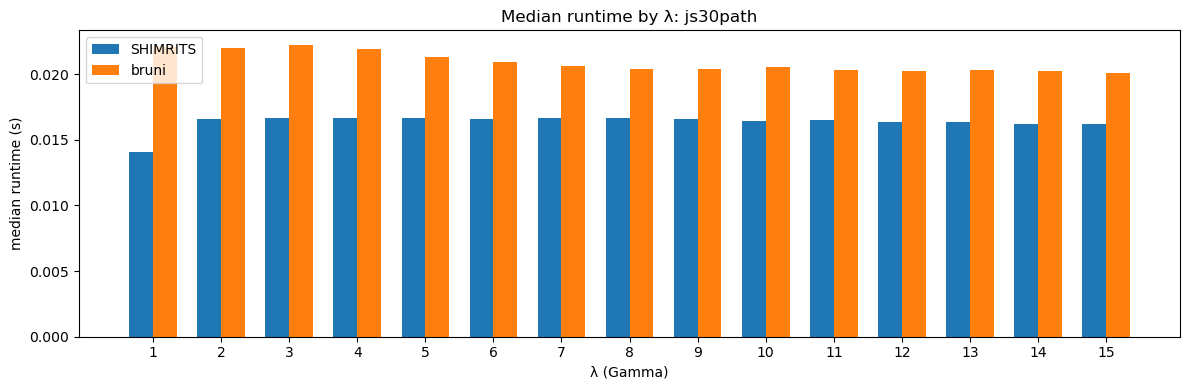

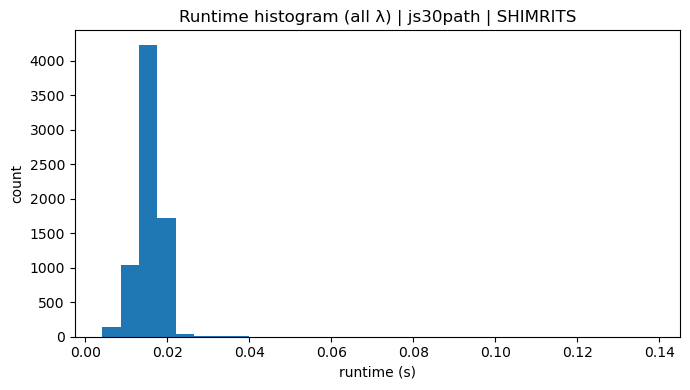

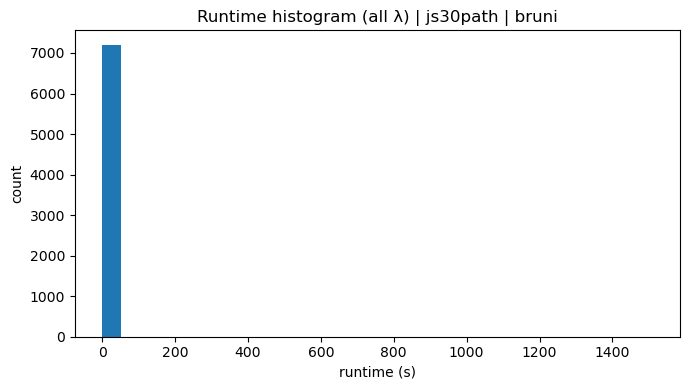

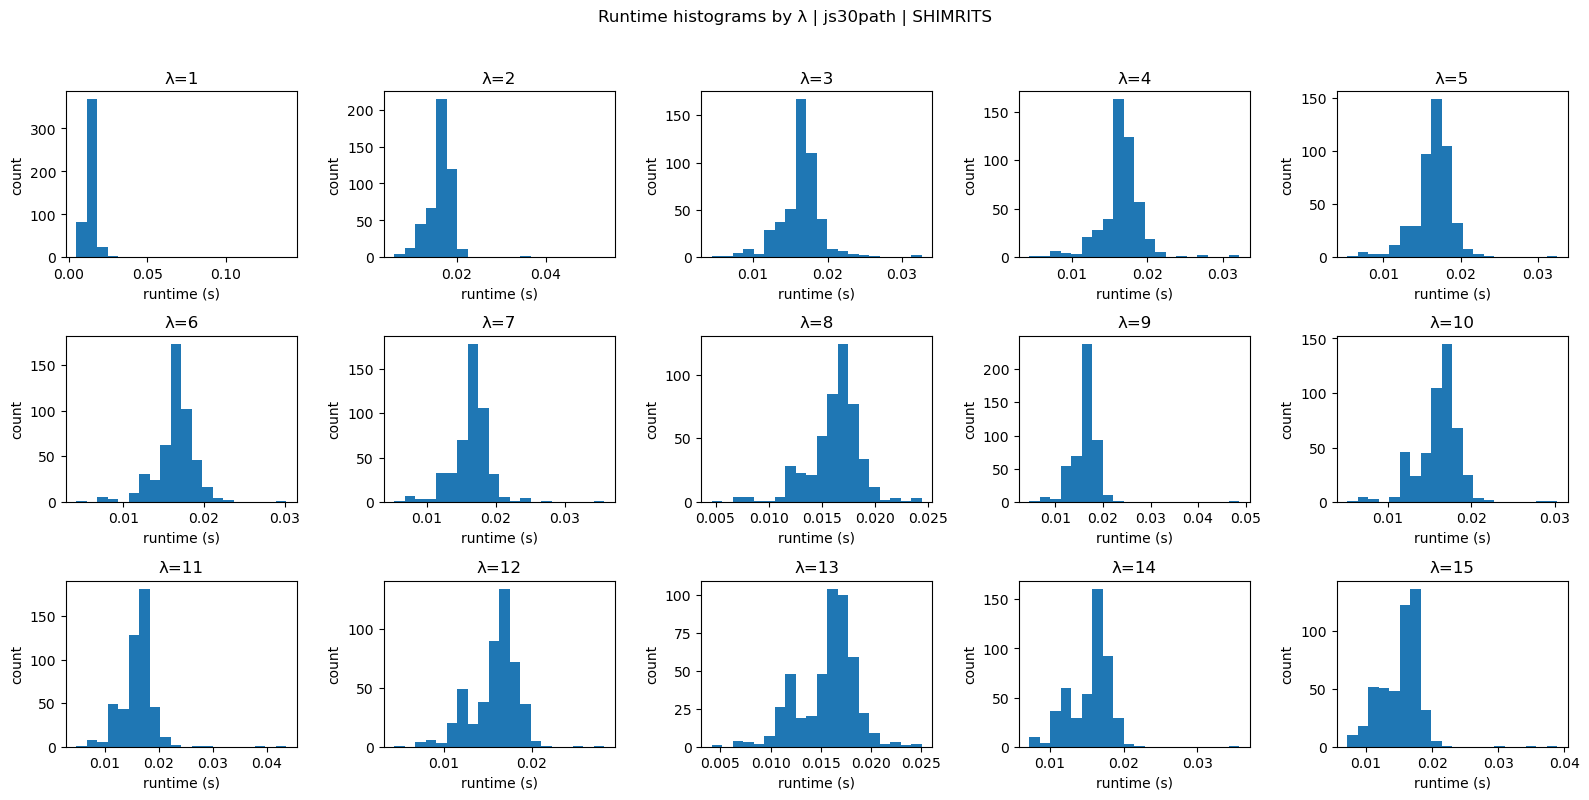

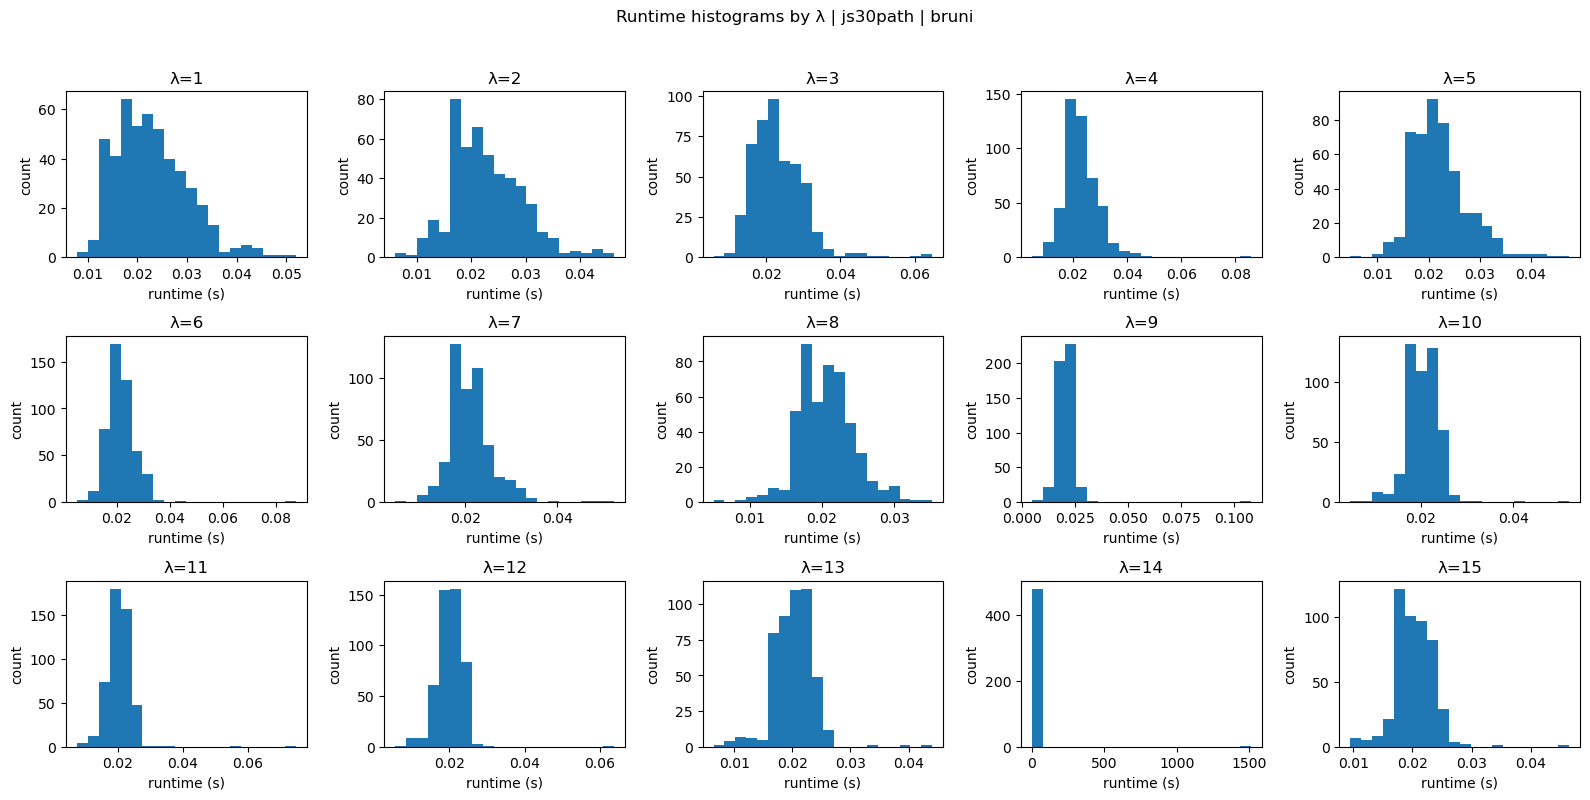

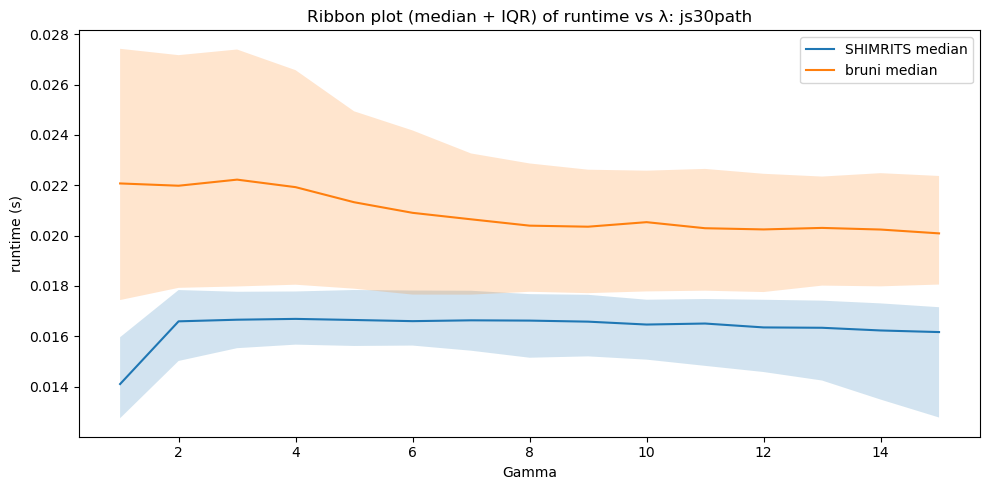

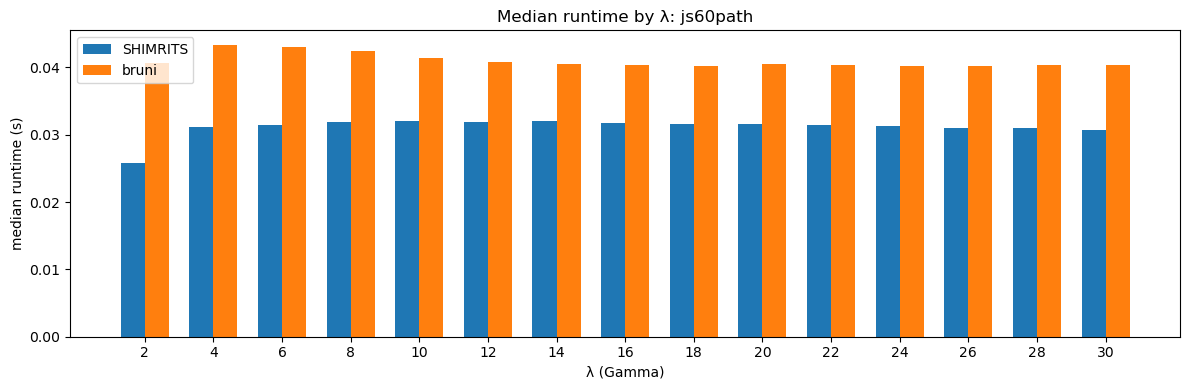

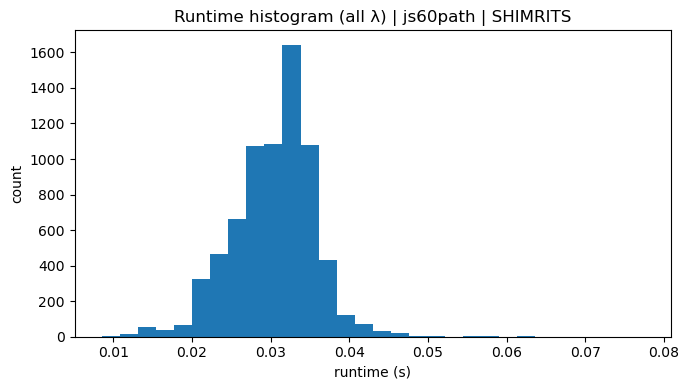

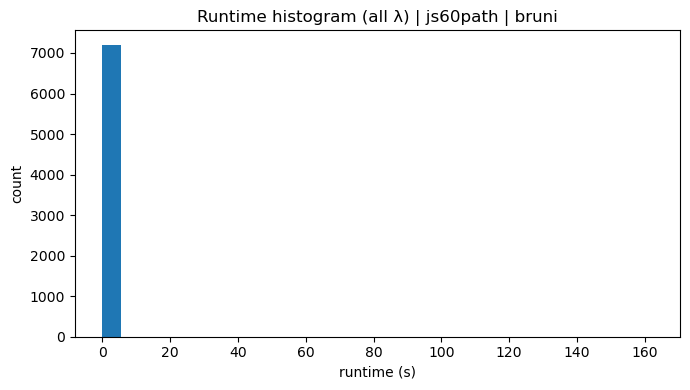

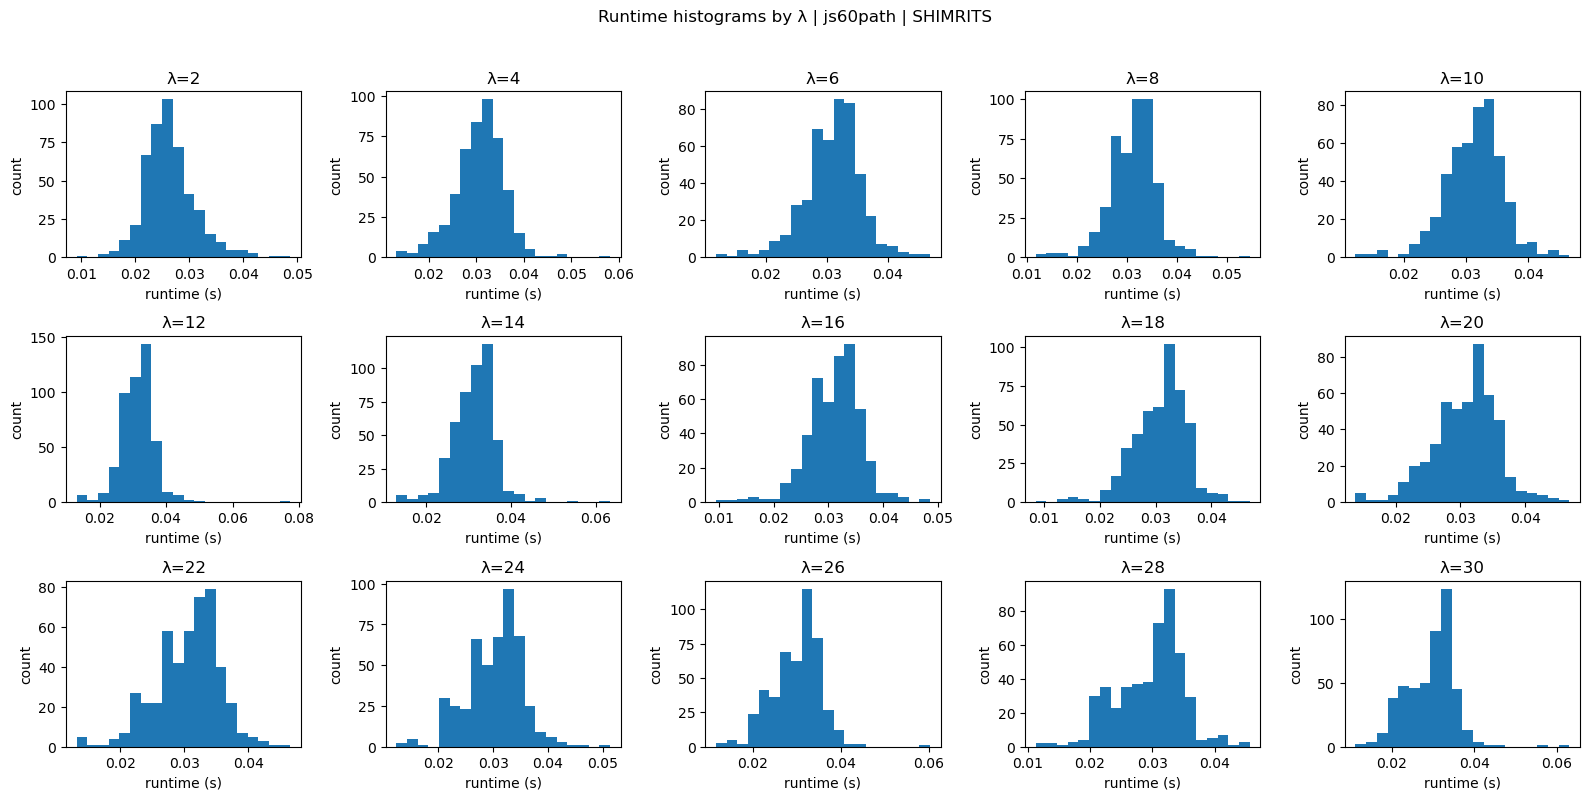

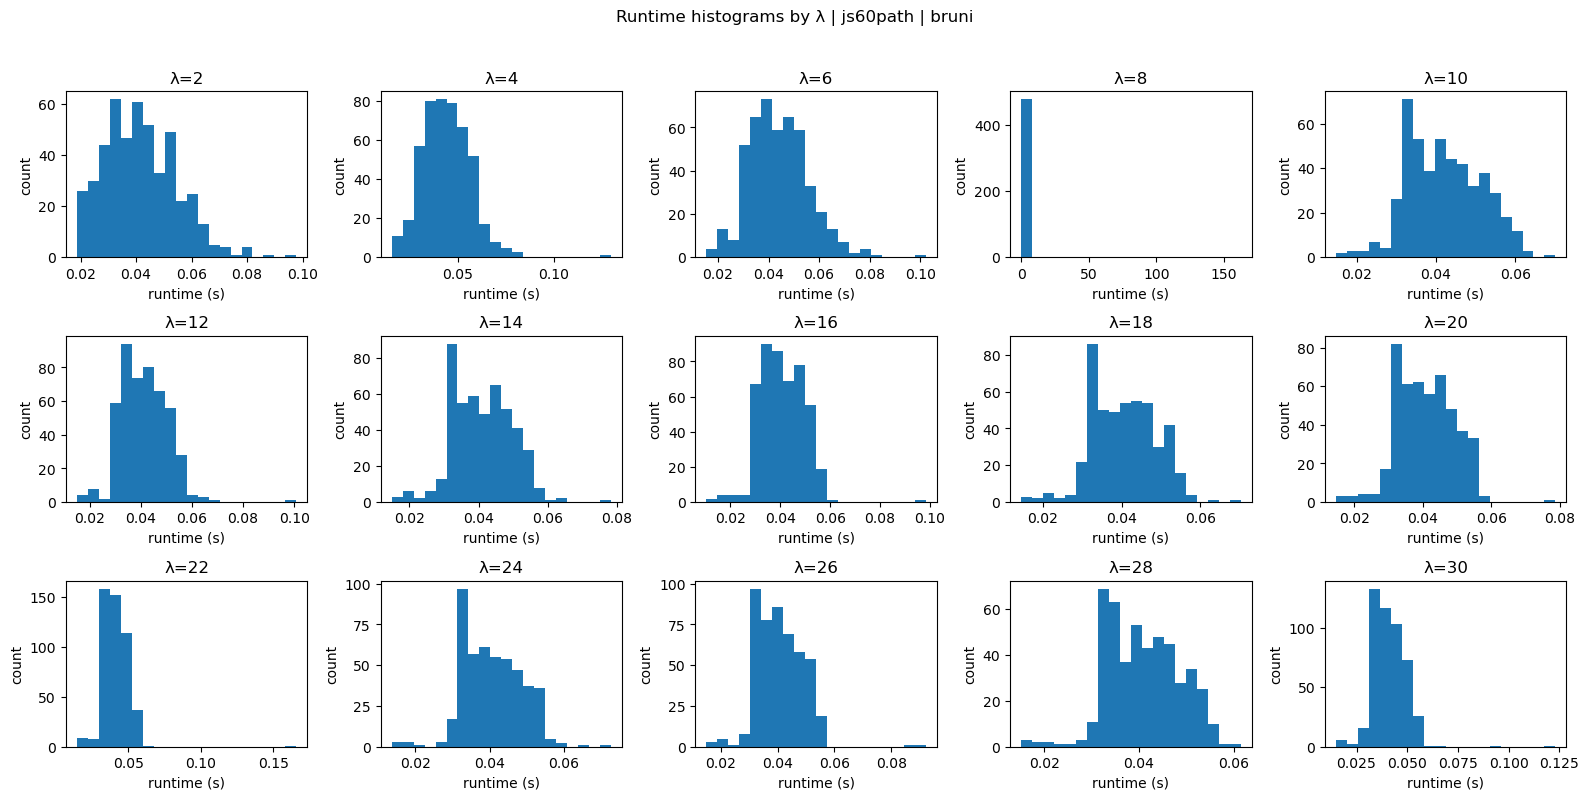

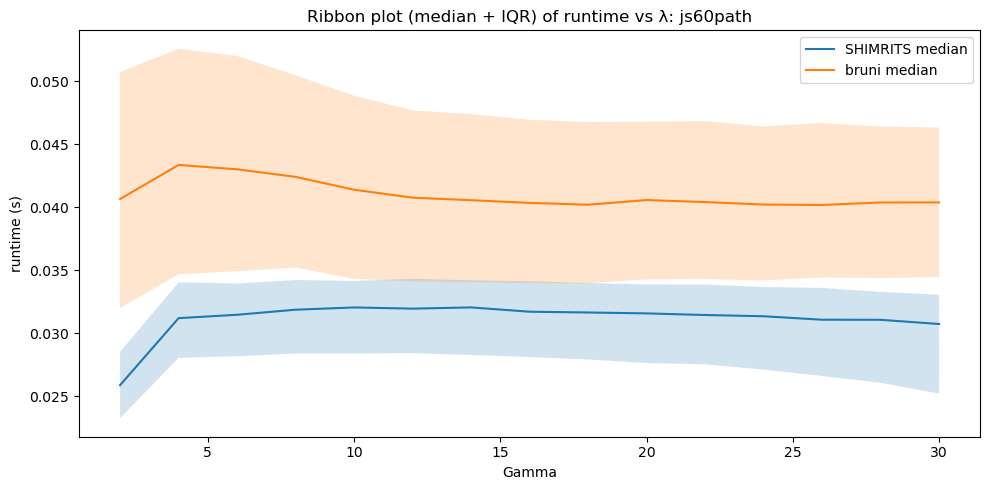

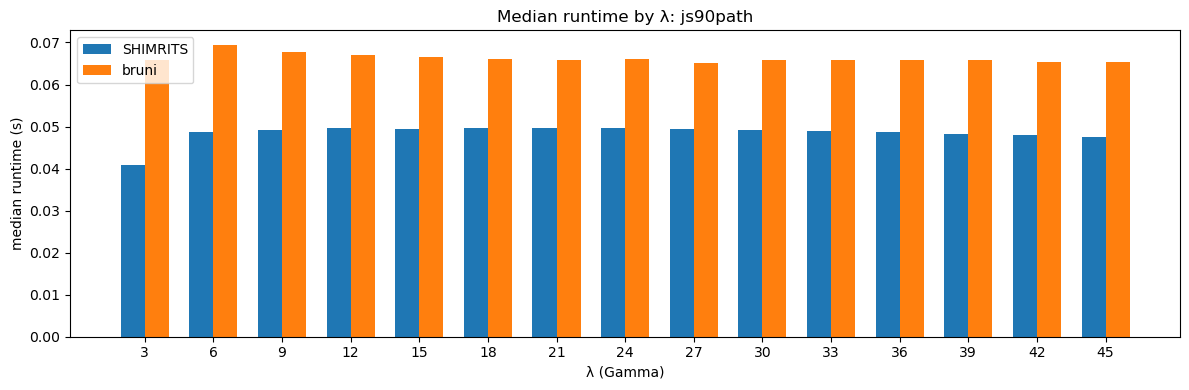

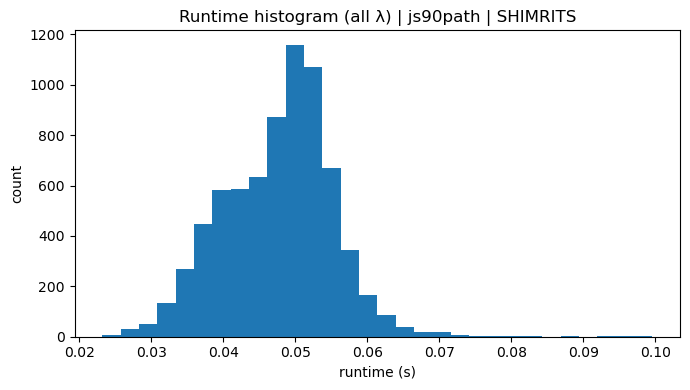

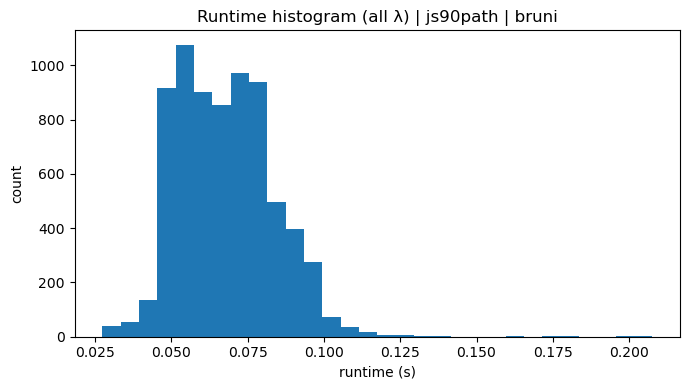

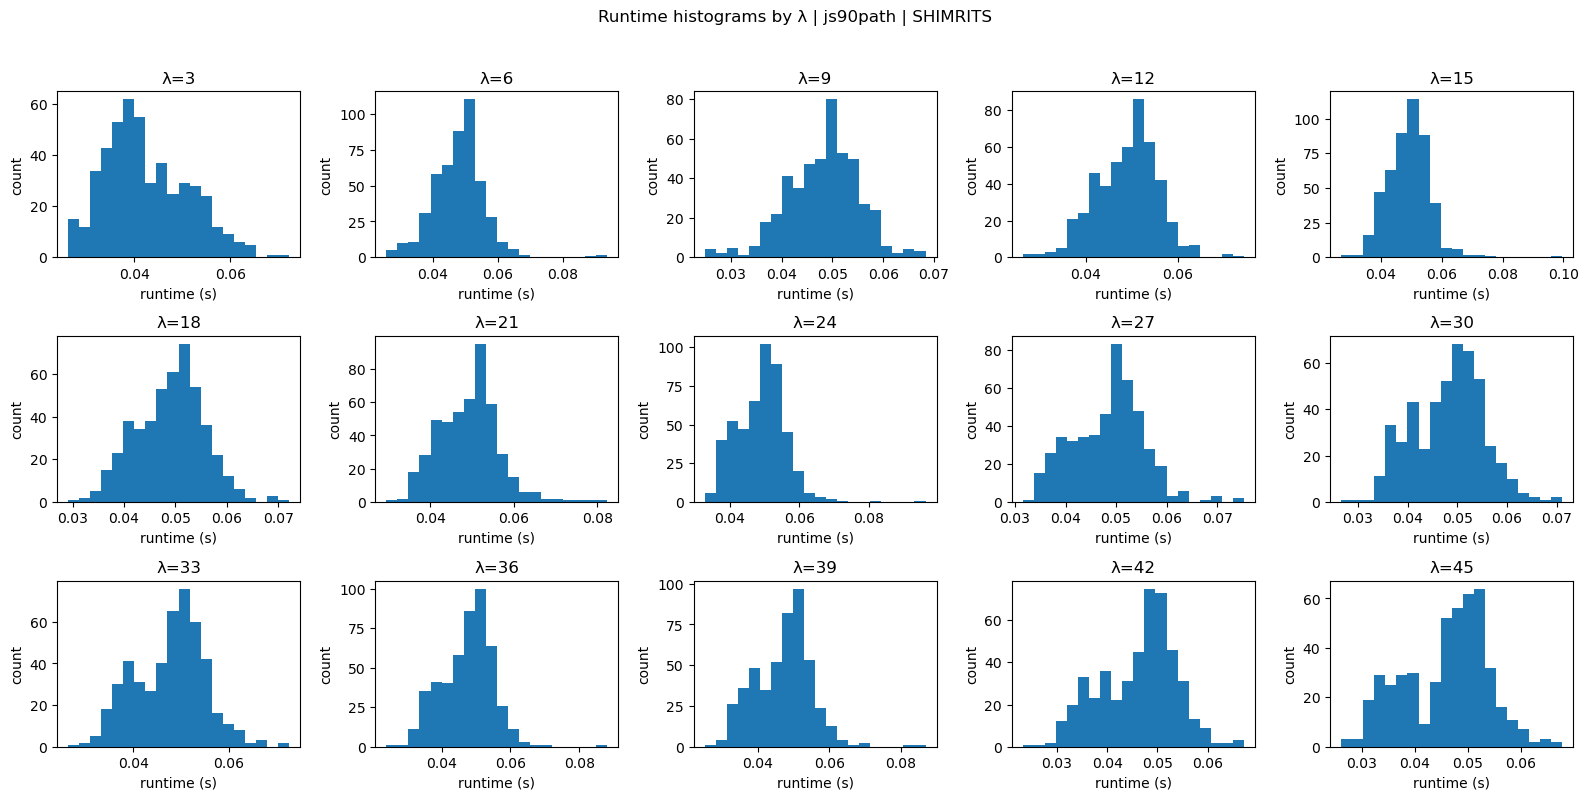

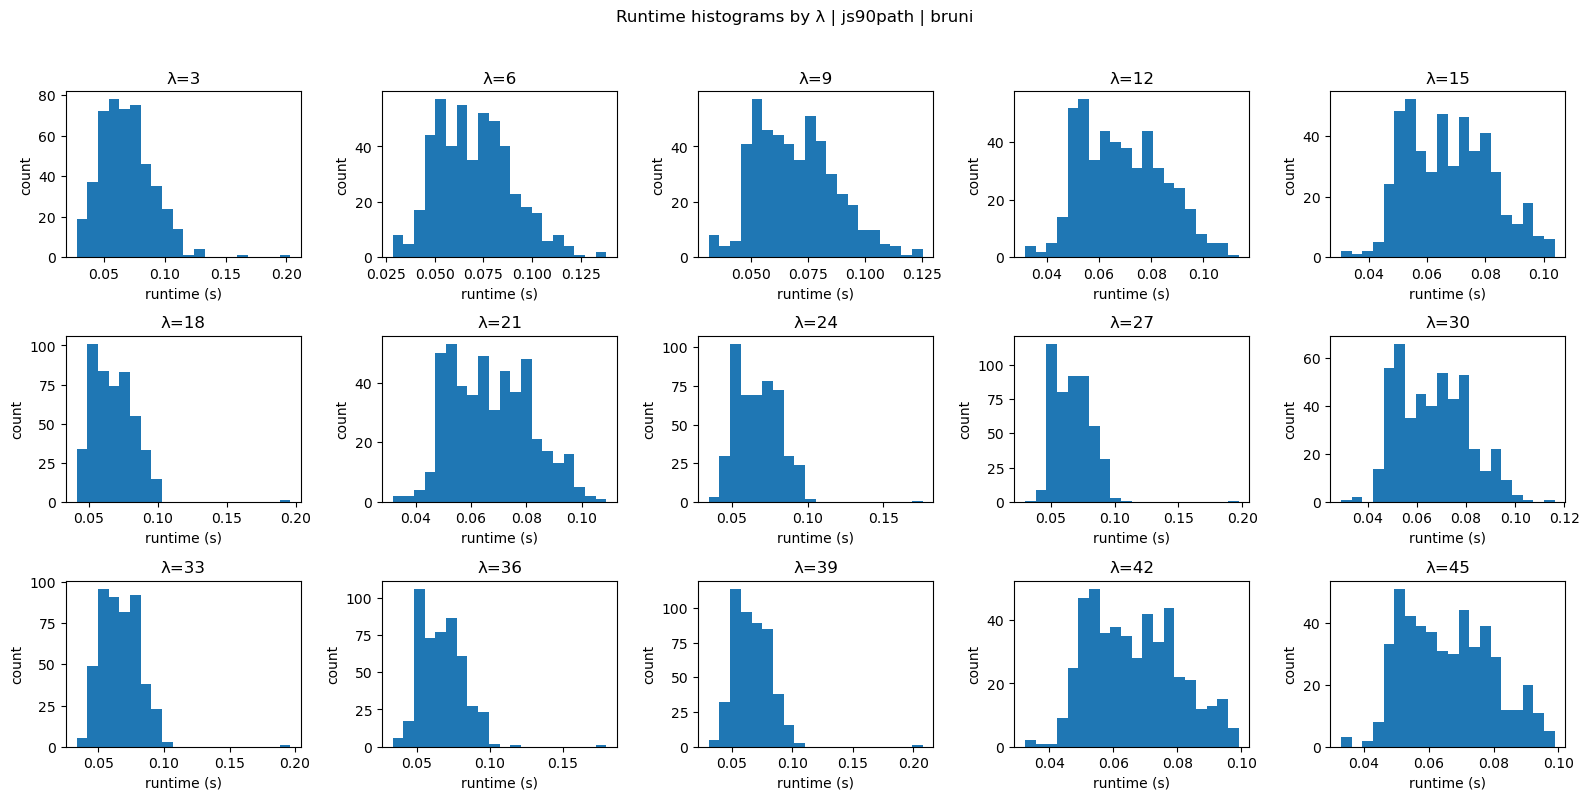

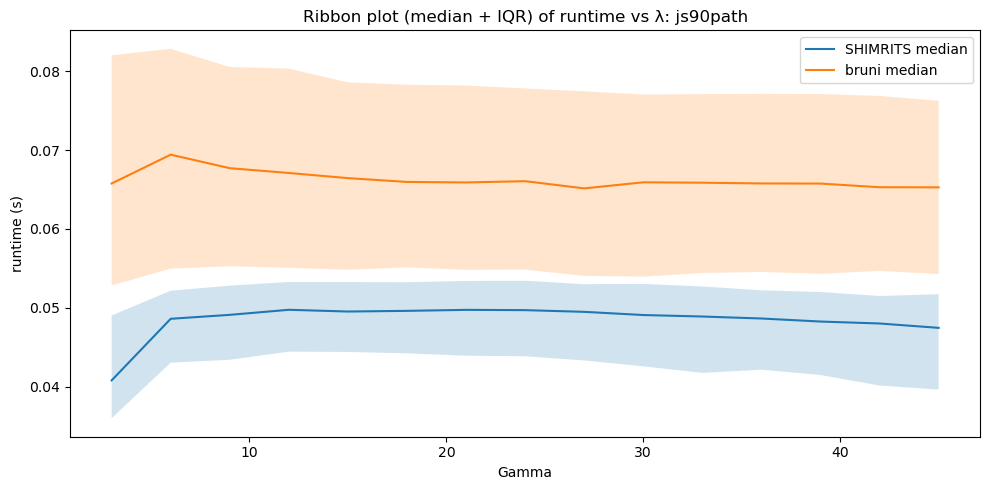

In [12]:
for dataset_name in sorted(df["dataset"].unique()):
    # Median bar
    plot_bar_median_per_dataset(df, dataset_name)

    # Histograms
    plot_hist_runtime_per_solver_all_gammas(df, dataset_name, bins=30)

    # Histograms by Gamma (grid) for each solver
    for solver in sorted(df[df["dataset"] == dataset_name]["solver"].unique()):
        plot_hist_runtime_by_gamma_grid(df, dataset_name, solver, bins=20, max_cols=5)

    # Ribbon plot (median + IQR)
    plot_ribbon_iqr_per_dataset(df, dataset_name)


In [11]:
import numpy as np
import pandas as pd
from scipy import stats


def paired_one_sided_ttest_from_txt(
    txt_path,
    new_solver="SHIMRITS",
    baseline_solver="bruni",
    key_cols=("dataset", "file", "Gamma"),
    runtime_col="runtime",
):
    # parse
    df = parse_results_txt(txt_path)

    # keep only relevant solvers
    df = df[df["solver"].isin([new_solver, baseline_solver])].copy()

    # clean runtimes
    df = df[np.isfinite(df[runtime_col]) & (df[runtime_col] > 0)]

    # pair observations
    pivot = df.pivot_table(
        index=list(key_cols),
        columns="solver",
        values=runtime_col,
        aggfunc="first",
    ).reset_index()

    pivot = pivot.dropna(subset=[new_solver, baseline_solver])

    x = pivot[new_solver].to_numpy()
    y = pivot[baseline_solver].to_numpy()

    if len(x) < 2:
        raise ValueError(f"Not enough paired observations in {txt_path}")

    # differences (new - baseline)
    d = x - y
    n = len(d)
    dfree = n - 1

    # t statistic
    mean_d = d.mean()
    sd_d = d.std(ddof=1)
    t_stat = mean_d / (sd_d / np.sqrt(n))

    # one-sided p-value: H1: mean_d < 0
    p_value = stats.t.cdf(t_stat, df=dfree)

    # 95% CI (two-sided, standard reporting)
    alpha = 0.05
    tcrit = stats.t.ppf(1 - alpha / 2, df=dfree)
    ci_low = mean_d - tcrit * (sd_d / np.sqrt(n))
    ci_high = mean_d + tcrit * (sd_d / np.sqrt(n))

    return {
        "file": txt_path,
        "n_pairs": n,
        "mean_diff_new_minus_bruni": mean_d,
        "median_diff_new_minus_bruni": np.median(d),
        "t_stat": t_stat,
        "df": dfree,
        "p_value_one_sided": p_value,
        "ci95_mean_diff": (ci_low, ci_high),
        "mean_new_runtime": x.mean(),
        "mean_bruni_runtime": y.mean(),
    }


# =========================
# Run tests
# =========================
txt_files = [
    "results_js30path.txt",
    "results_js60path.txt",
    "results_js90path.txt",
]

results = []
for txt in txt_files:
    res = paired_one_sided_ttest_from_txt(txt)
    results.append(res)

summary = pd.DataFrame(results)
print(summary.to_string(index=False))


                file  n_pairs  mean_diff_new_minus_bruni  median_diff_new_minus_bruni     t_stat   df  p_value_one_sided                                  ci95_mean_diff  mean_new_runtime  mean_bruni_runtime
results_js30path.txt     7200                  -0.003001                    -0.002727 -84.640319 7199           0.000000 (-0.0030706385772472475, -0.002931624478308309)          0.010263            0.013264
results_js60path.txt     7200                  -0.006385                    -0.005763 -87.556824 7199           0.000000 (-0.0065279101292192365, -0.006242006815225209)          0.019080            0.025464
results_js90path.txt     7200                   0.099346                    -0.010082   0.899561 7199           0.815808     (-0.11714565735350861, 0.31583772263128634)          0.138868            0.039522
